# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

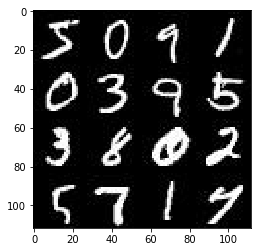

In [5]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

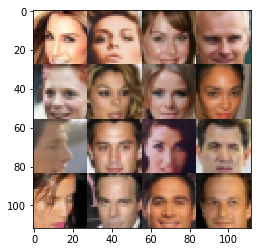

In [6]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


C:\Users\kenneth\Anaconda2\envs\dlnd2\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='l_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        ker_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        images_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer1 = tf.maximum(alpha * images_layer1, images_layer1)
        # 14x14x64
        
        images_layer2 = tf.layers.conv2d(images_layer1, 128, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer2 = tf.layers.batch_normalization(images_layer2, training=True)
        images_layer2 = tf.maximum(alpha * images_layer2, images_layer2)
        # 7x7x128
        
        images_layer3 = tf.layers.conv2d(images_layer2, 256, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer3 = tf.layers.batch_normalization(images_layer3, training=True)
        images_layer3 = tf.maximum(alpha * images_layer3, images_layer3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(images_layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        images_layer1 = tf.layers.dense(z, 7*7*256)
        images_layer1 = tf.reshape(images_layer1, (-1, 7, 7, 256))
        images_layer1 = tf.layers.batch_normalization(images_layer1, training=is_train)
        images_layer1 = tf.maximum(alpha * images_layer1, images_layer1)
        # 7x7x256
        
        ker_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        images_layer2 = tf.layers.conv2d_transpose(images_layer1, 128, 5, strides=1, padding='same',kernel_initializer=ker_initializer)
        images_layer2 = tf.layers.batch_normalization(images_layer2, training=is_train)
        images_layer2 = tf.maximum(alpha * images_layer2, images_layer2)
        # 7x7x128
        
        images_layer3 = tf.layers.conv2d_transpose(images_layer2, 64, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer3 = tf.layers.batch_normalization(images_layer3, training=is_train)
        images_layer3 = tf.maximum(alpha * images_layer3, images_layer3)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(images_layer3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        # 28x28x3
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    _,image_width, image_height, image_channels =data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    n_images =16
    print_every=10
    show_every=100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, l_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 1.4125
Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 1.6529
Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 2.4515
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.8549
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 2.1390
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 2.6403
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.1210


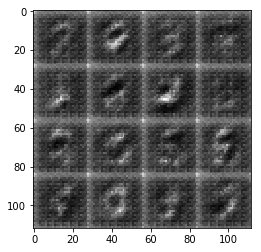

Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 3.0624
Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 2.2166
Epoch 1/2... Discriminator Loss: 0.3707... Generator Loss: 2.1088
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.9725
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 2.9203
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 1.7327
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 1.7267
Epoch 1/2... Discriminator Loss: 0.3917... Generator Loss: 2.2976
Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 1.5333


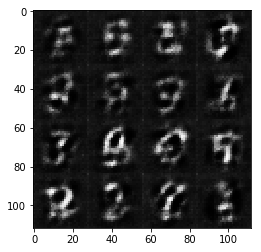

Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 2.8681
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.1895
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 1.4432
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 3.4448
Epoch 1/2... Discriminator Loss: 0.8031... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 2.5686
Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 1.1680
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 3.5223
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 0.9902


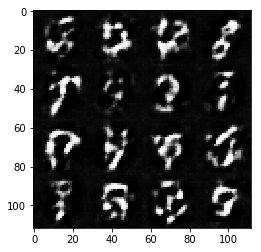

Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 1.8102
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 2.7250
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 2.8409
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 1.5226
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 1.5779
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 2.3192
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 2.0002


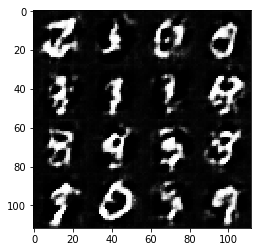

Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 1.4634
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 0.3964... Generator Loss: 1.6634
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 2.4868
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 2.9333
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 2.4616
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 3.3936
Epoch 2/2... Discriminator Loss: 0.5210... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.3009


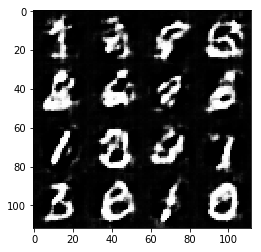

Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.7053
Epoch 2/2... Discriminator Loss: 2.4771... Generator Loss: 0.1259
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 0.5836... Generator Loss: 1.9948
Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 2.1773
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 1.2320
Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 1.5641
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.5967


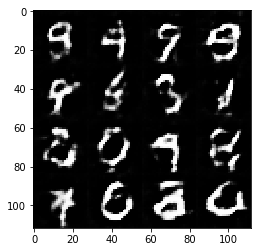

Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 2.5173
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 2.8483
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 2.1656
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 2.8155
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.8823
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.5380
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.4892


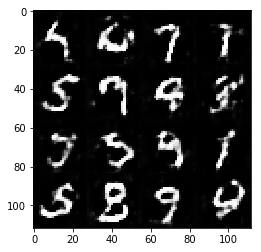

Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.2700
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 0.7537... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 1.6003
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 2.7211
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.7458
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.0534


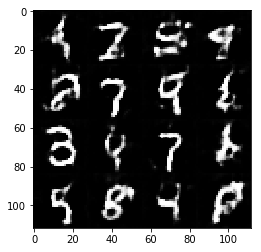

Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.7414
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 2.4885
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.0383
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.4697
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.5579
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3897


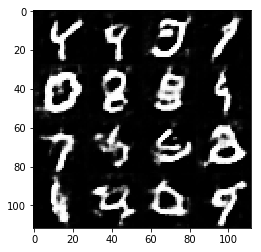

Epoch 2/2... Discriminator Loss: 1.9035... Generator Loss: 0.3897
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 1.6874


IndexError: list index out of range

In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 2.0870
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 2.7228
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 3.0238
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 3.0519
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.5096


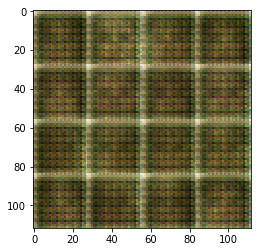

Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.7331... Generator Loss: 0.3648
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 4.2773
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 2.5824
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 2.1518... Generator Loss: 4.6069
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 2.8447
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6237


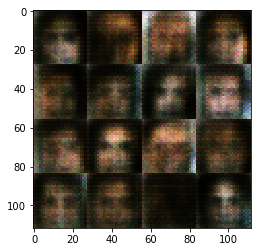

Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 2.2851
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.7521


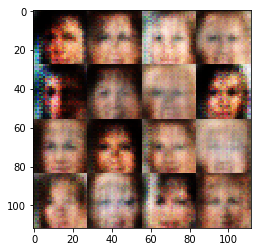

Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.6455
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.4983


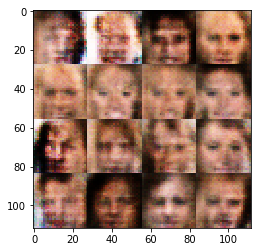

Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.8262


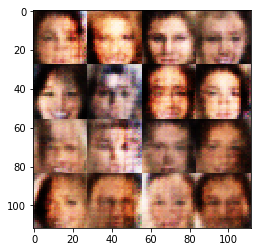

Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.1474


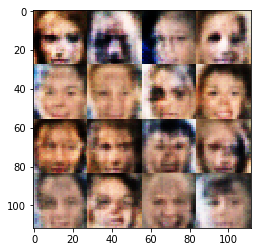

Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.3438


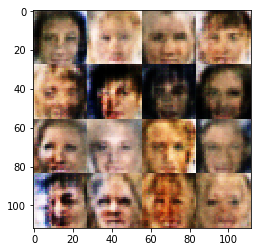

Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.0587


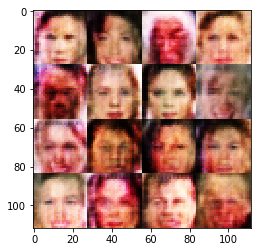

Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.2775
Epoch 1/1... Discriminator Loss: 1.8809... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.9715


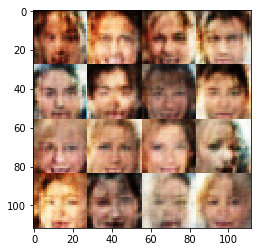

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.6313


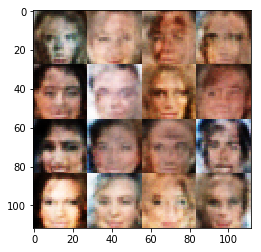

Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.0014


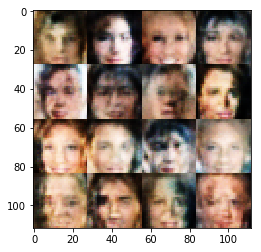

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 2.6018
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.5004
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.6808


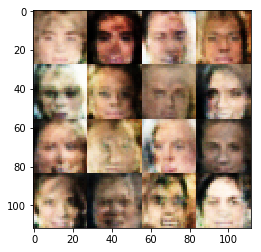

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.2994
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8109


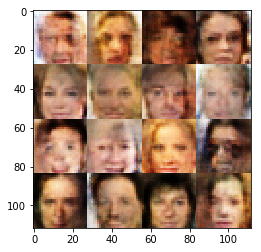

Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9516


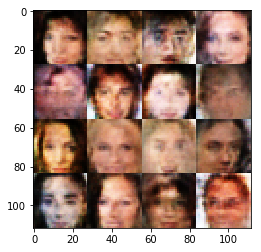

Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.3680
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.5438


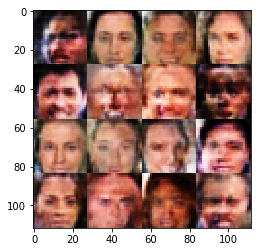

Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.2700


IndexError: list index out of range

In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.